In [1]:
import pandas as pd
import re

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
val = pd.read_csv("data/valid.csv")

In [21]:
def build_classifier_model(number_classes):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dropout(0.1)(net)
    # net = tf.keras.layers.Dense(number_classes, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [6]:
def execute_model(X_train, y_train, X_val, y_val, X_test, y_test, epochs):

    #we use label encoding to convert text labels to numeric, we go from ineffective -> 0 for example


    #we then need to convert the values to tensors, ensuring that the values are converted to strings.
    X_train = tf.convert_to_tensor(X_train.map(str))
    y_train = tf.convert_to_tensor(y_train)
    X_val = tf.convert_to_tensor(X_val.map(str))
    y_val = tf.convert_to_tensor(y_val)
    X_test = tf.convert_to_tensor(X_test.map(str))
    y_test = tf.convert_to_tensor(y_test)

    #extract the number of classes
    number_classes = len(set(y_train.numpy()))

    #build the model
    classifier_model = build_classifier_model(number_classes)
    #we use adam optimizer, as it is an industry standard, and the loss as sparse categorical crossentropy, as our labels are not one-hot encoded.
    classifier_model.compile(optimizer="adam",
                            loss='sparse_categorical_crossentropy',
                            metrics=['acc'])

    #we can then train the model
    print(f'Training model:')
    history = classifier_model.fit(X_train, y_train, validation_data = (X_val, y_val),
                               epochs=epochs)


    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend()
    plt.show()

    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='valid')
    plt.legend()
    plt.show()
    #evaluate the model
    print("Evaluating accuracy:")
    loss, accuracy = classifier_model.evaluate(X_test, y_test)

    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')

    #predict for the test data
    prediction = classifier_model.predict(X_test)
    y_pred = []
    for class_pos in prediction.argmax(axis=1):
        y_pred.append(class_pos)


    #show the f1 score and confusion matrix
    print(f"weighted f1-score:{f1_score(y_test, y_pred, average='weighted')}")

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize = (10,7))
    fig = sns.heatmap(df_cm, annot=True, fmt='g')
    fig.set(xlabel='Predicted', ylabel='Actual')

# BERT

In [16]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [8]:
X_train, y_train = train.clean_text, train.label
X_test, y_test = test.clean_text, test.label
X_val, y_val = val.clean_text, val.label

Training model:
Epoch 1/5
102/102 [==============================] - 22s 174ms/step - loss: 1.0785 - acc: 0.5674 - val_loss: 0.8448 - val_acc: 0.7032
Epoch 2/5
102/102 [==============================] - 17s 164ms/step - loss: 0.6126 - acc: 0.7854 - val_loss: 0.9163 - val_acc: 0.6631
Epoch 3/5
102/102 [==============================] - 17s 162ms/step - loss: 0.3214 - acc: 0.8975 - val_loss: 0.9917 - val_acc: 0.7193
Epoch 4/5
102/102 [==============================] - 17s 169ms/step - loss: 0.2327 - acc: 0.9260 - val_loss: 1.2016 - val_acc: 0.6925
Epoch 5/5
102/102 [==============================] - 17s 171ms/step - loss: 0.1487 - acc: 0.9515 - val_loss: 1.4881 - val_acc: 0.6631


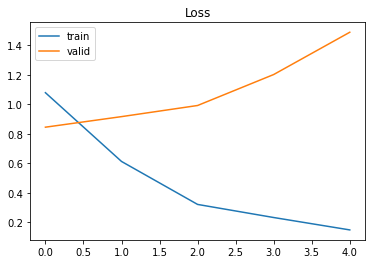

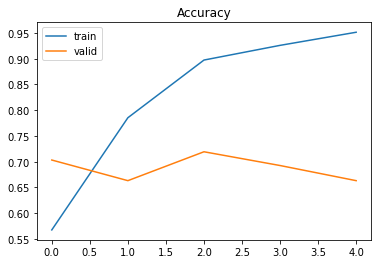

Evaluating accuracy:
45/45 [==============================] - 6s 124ms/step - loss: 1.4317 - acc: 0.6937
Loss: 1.431746482849121
Accuracy: 0.6936619877815247
weighted f1-score:0.6921317442583821


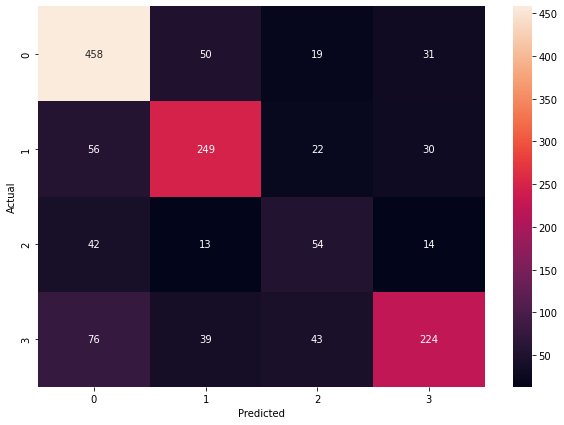

In [17]:
execute_model(X_train, y_train,X_val, y_val, X_test, y_test, 5)

In [ ]:
execute_model(X_train, y_train,X_val, y_val, X_test, y_test, 10)

## Roberta

In [19]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1")

bert_model = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1", trainable=True)

tfhub_handle_encoder="https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1"
tfhub_handle_preprocess="https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1"

In [27]:
execute_model(X_train, y_train,X_val, y_val, X_test, y_test, 5)

KeyboardInterrupt: 

In [ ]:
execute_model(X_train, y_train,X_val, y_val, X_test, y_test, 10)